In [177]:
import os
import pandas as pd 
import logging
from datetime import date

### Setup

In [178]:
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level=logging.INFO)

In [179]:
pd.set_option('display.max_columns', None)

In [180]:
for p in ['raw', 'cleaned', 'production', 'helpers']:
    if not os.path.exists(p):
       os.makedirs(p)

In [181]:
import hashlib
import logging
import pandas as pd
import glob
import emoji


logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level=logging.INFO)

REQ_COLS = [
    'year', 
    'state', 
    'commodity_name', 
    'acres_planted',
    'acres_harvested',
    'tons_harvested',
    'us_dollars_harvested',
    'percent_maturity'
]

ISSUES = []

def open_file(file_path):
    try: 
        df = pd.read_csv(file_path, index_col=0)
        logging.info(f"reading data...")
        yield df
    except pd.errors.ParserError as e:
        logging.logging.critical(f"file at {file_path} not formatted as .csv")
        raise e
    

def make_hash_id(df, *column):
    """
    Create unique identifier for each row of data to avoid dups in database.
    eg: make_hash_id(df, "permalink", "type", "uuid").
    
    """
    df['uid'] = df[list(column)].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    df['uid'] = df['uid'].str.encode('utf-8').apply(lambda x: (hashlib.sha512(x).hexdigest().upper()))
    logging.info(f'uid hashes created for rows in dataset')
    return df

def remove_dups(df):
    """
    Drop column is hashed uid is duplicate. Must be run after "make_hash_id"
    """
    logging.info("Checking for and removing duplicates rows..")
    return df.drop_duplicates(subset='uid', keep="first")



def df_lowerize(df):
    logging.info("Converting strings to lower..")
    return df.applymap(lambda s: s.lower() if type(s) == str else s)


def create_schema(df):
    schema = df.dtypes.map(lambda x: x.name).to_dict()
    return schema


def validate_farm_data_schema(df, schema, required=REQ_COLS):
    df_schema = create_schema(df)
    
    if not schema == df_schema:
        #log validating schema pass
        return None
    else:
        return df
    


# def validate_schema(df, schema):
#     schema =  FARM_DATA_SCHEMA
    
#     if not schema:
#         logging.critical(f"Cannot find schema file used for validation")
#         return 

    
#     missing = []
    
# #     df_col_ls = df.columns.to_list()
    
# #     for required_c in required_col_ls:
# #         if required_c not in df_col_ls:
# #             missing.append(required_c)
    
#     if len(missing) > 0:
#         logging.critical(f"Cannot process file <id> missing required cols: {missing}")
#         ISSUES.append("Missing required fields, cannot perform calculations.")

#         return missing
    
#     return None

def drop_nan_rows_in_required_cols(df):
    logging.info("Dropping rows with nan/null in required cols.")
    return df.dropna(axis=0, subset=REQ_COLS)

def find_nan_columns(df):
    
    if len(nan_cols)>0:
        logging.info(f"Found null/nan values in columns: {nan_cols}")
        try: 
            logging.info("Processing nan columns...")
            drop_rows_nan_in_required_col(df)
            fillna_num_cols(df)

            logging.info("Processed all nan/null columns...")
        except: 
            logging.info(f"Found null/nan values in columns: {nan_cols}")
            ISSUES.append("Unprocessed nan/null values")
            
        return
            
    else:
        logging.info("No nan/null columns found. Process complete.")
        return 


def path_files_to_ls(path):
    file_ls = []
 
    for (root, dirs, file) in os.walk(path):
        for f in file:
            if '.csv' in f:
                file_ls.append(f)
    
    return file_ls
    
    
def run_cleaning_pipeline(files: list, pipeline: str):
    """
    We don't want to exit the program if a file cannot be processed. 
    Instead, we log the error, move the file to the "errors" folder and continue.
    """
    f_ct = len(files)
    f_fail = []
    
    for f in files:
        try:
            f.apply(pipeline)
        except: 
            f_fail.append(f)
            logging.critical(f'Could not process file: {f} moving to dir: "errors/"')
            #remove file from path and relocate
            #save ISSUES to text files in some location
    
    fail_ct = len(f_fail)
    
    if fail_ct > 0:
        logging.critical(f'{emoji.emojize(":zipper-mouth_face:")}: {fail_ct} of {f_ct} files could not be processed. Review new files at "errors/" and try again.')
    
    logging.info(f'All files processed! {emoji.emojize(":grinning_face_with_big_eyes:")}')
    return

In [182]:
# %%writefile helpers/calculations.py


def calc_tons_never_harvested(df):
    logging.info(f'Calculating tons never harvested for <filename>"')

    df['tons_never_harvested'] = df['acres_unharvested'] * df['yield_tons_per_acre'] * df['percent_maturity']
    
    return df

def calc_tons_never_harvested_causes(df):
    logging.info(f'Calculating tons never by cause.')
#     causes_db = pd.read_csv('farm_not_harvested_causes.csv')
    #merge dfs with summing
    pass
    



# Part 1: Load and Process Initial Data

1. Load farm_part_1.csv
2. Convert all strings to lowercase
3. Check to make sure data is complete and there are no duplicates or other potential problems
4. Save a v1 version of the 'clean' raw dataset.

In [183]:
import hashlib

farm_data = pd.read_csv("/Users/margiehenry/Downloads/wetransfer_farm_not_harvested_causes-csv_2022-11-16_1428/farm_part_1.csv", index_col=0)

bad_df = pd.read_csv("/Users/margiehenry/Downloads/wetransfer_farm_not_harvested_causes-csv_2022-11-16_1428/farm_not_harvested_causes.csv")
#create schema on first run

FARM_DATA_SCHEMA = create_schema(farm_data)

 
# #1 validate schema
print(validate_farm_data_schema(farm_data, FARM_DATA_SCHEMA ))


# #2 to lower 
df_lower = df_lowerize(farm_data)


# # 3 check for and handle missing values in required rows 
req_no_nan = drop_nan_rows_in_required_cols(df_lower)
req_no_nan


# # # 4 hash for dups
df_hashed = make_hash_id(req_no_nan, 'year', 'state', 'commodity_name')


# # # 5 remove dups 
df_no_dups = remove_dups(df_hashed)

# # fillin refed_food_department	refed_food_category with previous seen 
df_no_dups


21-Nov-22 23:10:49 - Converting strings to lower..
21-Nov-22 23:10:49 - Dropping rows with nan/null in required cols.
21-Nov-22 23:10:49 - uid hashes created for rows in dataset
21-Nov-22 23:10:49 - Checking for and removing duplicates rows..


      year           state commodity_name refed_food_department  \
2202  2016         Alabama         PECANS             Dry goods   
2203  2016         Alabama        PEANUTS             Dry goods   
2204  2016         Arizona         PECANS             Dry goods   
2205  2016        Arkansas        PEANUTS             Dry goods   
2206  2016      California         PECANS             Dry goods   
...    ...             ...            ...                   ...   
3124  2018         Indiana     WATERMELON               Produce   
3125  2018        Maryland     WATERMELON               Produce   
3126  2018  North Carolina     WATERMELON               Produce   
3127  2018  South Carolina     WATERMELON               Produce   
3128  2018           Texas     WATERMELON               Produce   

     refed_food_category  acres_planted  acres_harvested  \
2202      Nuts and seeds         8900.0           8900.0   
2203      Nuts and seeds       175000.0         172000.0   
2204      Nuts 

,year,state,commodity_name,refed_food_department,refed_food_category,acres_planted,acres_harvested,us_dollars_harvested,tons_harvested,percent_maturity,uid
2202,2016,alabama,pecans,dry goods,nuts and seeds,8900.0,8900.0,4467000.0,1100.0,0.5,114D11AF85C5F71BA5F4200395075C725DF791EB68C6D0...
2203,2016,alabama,peanuts,dry goods,nuts and seeds,175000.0,172000.0,121982000.0,309600.0,0.5,2F5D972CA3E3D1DE3929211C39EF55D71E895378180E1D...
2204,2016,arizona,pecans,dry goods,nuts and seeds,15000.0,15000.0,67208000.0,12400.0,0.5,1167043B641F38317A6AAF4910F5641DB52D257582B8E3...
2205,2016,arkansas,peanuts,dry goods,nuts and seeds,24000.0,23000.0,20424000.0,55200.0,0.5,59B08A276DE56E1DE2EAF474E33A34566698C7DE8D7BBC...
2206,2016,california,pecans,dry goods,nuts and seeds,3500.0,3500.0,14656000.0,2885.0,0.5,2C8CF0CEBDF0FE536818C44B0B7D9A5D7EEBF805A051E1...
...,...,...,...,...,...,...,...,...,...,...,...
3124,2018,indiana,watermelon,produce,watermelons,6600.0,6500.0,27915000.0,152750.0,0.5,E9693DB3EF776B12A8075474FDB59E4A7707656843E802...
3125,2018,maryland,watermelon,produce,watermelons,3700.0,3500.0,10395000.0,52500.0,0.5,B66F4465E092CD8B8C57A4CFD44BCB026C22DF1F6F99B8...
3126,2018,north carolina,watermelon,produce,watermelons,7700.0,7300.0,22314000.0,91250.0,0.5,72E76C2308688BD79449C8076ED8E45F5737B21A9B1947...
3127,2018,south carolina,watermelon,produce,watermelons,4500.0,4300.0,17174000.0,49450.0,0.5,EC6CB3FCFD7773B50728D430A6BB1D3188DD39EF3C8C28...


In [184]:
# run as pipline as save

import os

FARM_DATA_SCHEMA = {'year': 'int64', 'state': 'object', 'commodity_name': 'object', 'refed_food_department': 'object', 'refed_food_category': 'object', 'acres_planted': 'float64', 'acres_harvested': 'float64', 'us_dollars_harvested': 'float64', 'tons_harvested': 'float64', 'percent_maturity': 'float64'}


class CleaningPipeline:
    def __init__(self, FarmDataPath, FARM_DATA_SCHEMA):
        self.path = FarmDataPath
        self.schema = FARM_DATA_SCHEMA
        self.filename = os.path.split(FarmDataPath)[1]
        self.df = None

        return None
       
    def open_csv(self):
        try: 
            self.df = pd.read_csv(self.path, index_col=0).apply(lambda x: x.astype(str).str.lower())
            logging.info(f"Reading data from {self.filename}.")
            return self.df
        
        except pd.errors.ParserError as e:
            logging.logging.critical(f"file at {self.filename} not formatted as .csv")
            raise e
    
    def validate_farm_data_schema(self, df, required=REQ_COLS):    
        df_schema = create_schema(df)
        
        if not self.schema == df_schema:
            logging.info(f"{self.filename} failed validation with schema {self.schema}")
#             return None
            return self.df
        else:
            logging.info(f"{self.filename} passed validation with schema {self.schema}")
            return df
        
    def make_hash_id(self, df, *column):
        df['uid'] = df[list(column)].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
#         df['uid'] = df['uid'].str.encode('utf-8').apply(lambda x: (hashlib.sha512(x).hexdigest().upper()))
        logging.info(f'uid hashes created for rows in dataset')
        return df

    
    

# pipeline = CleaningPipeline(
#     "/Users/margiehenry/Downloads/wetransfer_farm_not_harvested_causes-csv_2022-11-16_1428/farm_part_1.csv",
#     "/src/schema")


# cleaned_data = pipeline.open_csv().pipe(pipeline.validate_farm_data_schema).pipe(pipeline.make_hash_id, 'year', 'state', 'commodity_name')\
#                 .pipe(drop_nan_rows_in_required_cols)\
#                 .pipe(make_hash_id, 'year', 'state', 'commodity_name')\
#                 .pipe(remove_dups)

# cleaned_data


## Part1 Continued 

5. Calculate tons_never_harvested for each item (each row) and append to dataset (See appendix 1 for
how to calculate tons_never_harvested)
6. Load farm_not_harvested_causes.csv
7. Calculate amount of food not harvested (tons_never_harvested) for each 'cause' (the reason for why
that food was not harvest) for each item (row) and append to dataset (see appendix 1 for calculation)
8. Save a v1 'production' dataset in the format of your choice

In [185]:
def calc_tons_never_harvested(df):
    df["acres_unharvested"] = df["acres_planted"] - df["acres_harvested"]
    df["yield_tons_per_acre"] = df["tons_harvested"].div(df["acres_harvested"].values)
    df["price_per_ton"] = df["us_dollars_harvested"].div(df["tons_harvested"].values)
    df["tons_never_harvested"] = (df["acres_unharvested"] * df["yield_tons_per_acre"] * df["percent_maturity"])
    return df

df_nh = calc_tons_never_harvested(df_no_dups)
df_nh

,year,state,commodity_name,refed_food_department,refed_food_category,acres_planted,acres_harvested,us_dollars_harvested,tons_harvested,percent_maturity,uid,acres_unharvested,yield_tons_per_acre,price_per_ton,tons_never_harvested
2202,2016,alabama,pecans,dry goods,nuts and seeds,8900.0,8900.0,4467000.0,1100.0,0.5,114D11AF85C5F71BA5F4200395075C725DF791EB68C6D0...,0.0,0.123596,4060.909091,0.0
2203,2016,alabama,peanuts,dry goods,nuts and seeds,175000.0,172000.0,121982000.0,309600.0,0.5,2F5D972CA3E3D1DE3929211C39EF55D71E895378180E1D...,3000.0,1.800000,393.998708,2700.0
2204,2016,arizona,pecans,dry goods,nuts and seeds,15000.0,15000.0,67208000.0,12400.0,0.5,1167043B641F38317A6AAF4910F5641DB52D257582B8E3...,0.0,0.826667,5420.000000,0.0
2205,2016,arkansas,peanuts,dry goods,nuts and seeds,24000.0,23000.0,20424000.0,55200.0,0.5,59B08A276DE56E1DE2EAF474E33A34566698C7DE8D7BBC...,1000.0,2.400000,370.000000,1200.0
2206,2016,california,pecans,dry goods,nuts and seeds,3500.0,3500.0,14656000.0,2885.0,0.5,2C8CF0CEBDF0FE536818C44B0B7D9A5D7EEBF805A051E1...,0.0,0.824286,5080.069324,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,2018,indiana,watermelon,produce,watermelons,6600.0,6500.0,27915000.0,152750.0,0.5,E9693DB3EF776B12A8075474FDB59E4A7707656843E802...,100.0,23.500000,182.749591,1175.0
3125,2018,maryland,watermelon,produce,watermelons,3700.0,3500.0,10395000.0,52500.0,0.5,B66F4465E092CD8B8C57A4CFD44BCB026C22DF1F6F99B8...,200.0,15.000000,198.000000,1500.0
3126,2018,north carolina,watermelon,produce,watermelons,7700.0,7300.0,22314000.0,91250.0,0.5,72E76C2308688BD79449C8076ED8E45F5737B21A9B1947...,400.0,12.500000,244.536986,2500.0
3127,2018,south carolina,watermelon,produce,watermelons,4500.0,4300.0,17174000.0,49450.0,0.5,EC6CB3FCFD7773B50728D430A6BB1D3188DD39EF3C8C28...,200.0,11.500000,347.300303,1150.0


In [186]:
causes_data = pd.read_csv("/Users/margiehenry/Downloads/wetransfer_farm_not_harvested_causes-csv_2022-11-16_1428/farm_not_harvested_causes.csv")
causes_data

,cause,rate
0,not_marketable,0.28000
1,inedible,0.28000
2,bad_weather,0.04200
3,pests_disease,0.00063
4,market_dynamics,0.00013
5,other,0.39724


In [187]:
causes_data.set_index('cause').transpose()

cause,not_marketable,inedible,bad_weather,pests_disease,market_dynamics,other
rate,0.28,0.28,0.042,0.00063,0.00013,0.39724


In [204]:
def calc_tons_never_harvested_by_cause(farm_df, causes_df, col_name):
    i = 0
    for i in range(len(causes_df)):
        cause, rate = causes_df.iloc[i]
        farm_df[f"{col_name}_{cause}"] = farm_df[col_name].apply(lambda x: x * rate)
        i += 1

    return farm_df

nh_by_cause_df = calc_tons_never_harvested_by_cause(df_nh, causes_data, 'tons_never_harvested')
nh_by_cause_df

,year,state,commodity_name,refed_food_department,refed_food_category,acres_planted,acres_harvested,us_dollars_harvested,tons_harvested,percent_maturity,uid,acres_unharvested,yield_tons_per_acre,price_per_ton,tons_never_harvested,tons_never_harvested_not_marketable,tons_never_harvested_inedible,tons_never_harvested_bad_weather,tons_never_harvested_pests_disease,tons_never_harvested_market_dynamics,tons_never_harvested_other
2202,2016,alabama,pecans,dry goods,nuts and seeds,8900.0,8900.0,4467000.0,1100.0,0.5,114D11AF85C5F71BA5F4200395075C725DF791EB68C6D0...,0.0,0.123596,4060.909091,0.0,0.0,0.0,0.00,0.00000,0.00000,0.000
2203,2016,alabama,peanuts,dry goods,nuts and seeds,175000.0,172000.0,121982000.0,309600.0,0.5,2F5D972CA3E3D1DE3929211C39EF55D71E895378180E1D...,3000.0,1.800000,393.998708,2700.0,756.0,756.0,113.40,1.70100,0.35100,1072.548
2204,2016,arizona,pecans,dry goods,nuts and seeds,15000.0,15000.0,67208000.0,12400.0,0.5,1167043B641F38317A6AAF4910F5641DB52D257582B8E3...,0.0,0.826667,5420.000000,0.0,0.0,0.0,0.00,0.00000,0.00000,0.000
2205,2016,arkansas,peanuts,dry goods,nuts and seeds,24000.0,23000.0,20424000.0,55200.0,0.5,59B08A276DE56E1DE2EAF474E33A34566698C7DE8D7BBC...,1000.0,2.400000,370.000000,1200.0,336.0,336.0,50.40,0.75600,0.15600,476.688
2206,2016,california,pecans,dry goods,nuts and seeds,3500.0,3500.0,14656000.0,2885.0,0.5,2C8CF0CEBDF0FE536818C44B0B7D9A5D7EEBF805A051E1...,0.0,0.824286,5080.069324,0.0,0.0,0.0,0.00,0.00000,0.00000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,2018,indiana,watermelon,produce,watermelons,6600.0,6500.0,27915000.0,152750.0,0.5,E9693DB3EF776B12A8075474FDB59E4A7707656843E802...,100.0,23.500000,182.749591,1175.0,329.0,329.0,49.35,0.74025,0.15275,466.757
3125,2018,maryland,watermelon,produce,watermelons,3700.0,3500.0,10395000.0,52500.0,0.5,B66F4465E092CD8B8C57A4CFD44BCB026C22DF1F6F99B8...,200.0,15.000000,198.000000,1500.0,420.0,420.0,63.00,0.94500,0.19500,595.860
3126,2018,north carolina,watermelon,produce,watermelons,7700.0,7300.0,22314000.0,91250.0,0.5,72E76C2308688BD79449C8076ED8E45F5737B21A9B1947...,400.0,12.500000,244.536986,2500.0,700.0,700.0,105.00,1.57500,0.32500,993.100
3127,2018,south carolina,watermelon,produce,watermelons,4500.0,4300.0,17174000.0,49450.0,0.5,EC6CB3FCFD7773B50728D430A6BB1D3188DD39EF3C8C28...,200.0,11.500000,347.300303,1150.0,322.0,322.0,48.30,0.72450,0.14950,456.826


# Part 2: Analysis

1. Calculate total tons_never_harvested by year and refed_food_department (hint: For each year in the data set, there should a U.S. total for tons_never_harvested for dry goods and a total for produce)
2. Plot this table
3. Calculate the U.S. total of tons_never_harvested for each 'cause', aggregated by year and refed_food_department
4. Plot this table

In [190]:
out = df_nh.groupby(['refed_food_department', 'year'], as_index=False)[["tons_never_harvested"]].sum()
out


,refed_food_department,year,tons_never_harvested
0,dry goods,2016,101240.000000
1,dry goods,2017,84545.000000
2,dry goods,2018,49612.500000
3,produce,2016,609818.606878
4,produce,2017,651984.977968
5,produce,2018,632643.073394


In [203]:
# !pip3 install plotly
import plotly.express as px
fig = px.histogram(out, x="year", y="tons_never_harvested",
             color='refed_food_department', barmode='group',
             histfunc='sum',
             height=400, text_auto='.2s',
            title="Tons Never Harvested by year and Refed Food Department")
fig.show()

In [253]:
# out2 = nh_by_cause_df[['year', 'refed_food_department', 'tons_never_harvested']]

# cols = list(nh_by_cause_df.columns)
cols = ['year',
 'refed_food_department',
 'tons_never_harvested_not_marketable',
 'tons_never_harvested_inedible',
 'tons_never_harvested_bad_weather',
 'tons_never_harvested_pests_disease',
 'tons_never_harvested_market_dynamics',
 'tons_never_harvested_other']

out2 = nh_by_cause_df[cols]
out2

,year,refed_food_department,tons_never_harvested_not_marketable,tons_never_harvested_inedible,tons_never_harvested_bad_weather,tons_never_harvested_pests_disease,tons_never_harvested_market_dynamics,tons_never_harvested_other
2202,2016,dry goods,0.0,0.0,0.00,0.00000,0.00000,0.000
2203,2016,dry goods,756.0,756.0,113.40,1.70100,0.35100,1072.548
2204,2016,dry goods,0.0,0.0,0.00,0.00000,0.00000,0.000
2205,2016,dry goods,336.0,336.0,50.40,0.75600,0.15600,476.688
2206,2016,dry goods,0.0,0.0,0.00,0.00000,0.00000,0.000
...,...,...,...,...,...,...,...,...
3124,2018,produce,329.0,329.0,49.35,0.74025,0.15275,466.757
3125,2018,produce,420.0,420.0,63.00,0.94500,0.19500,595.860
3126,2018,produce,700.0,700.0,105.00,1.57500,0.32500,993.100
3127,2018,produce,322.0,322.0,48.30,0.72450,0.14950,456.826


In [252]:
final = out2.groupby(['year', 'refed_food_department'], as_index=False).sum()
final

,year,refed_food_department,tons_never_harvested_not_marketable,tons_never_harvested_inedible,tons_never_harvested_bad_weather,tons_never_harvested_pests_disease,tons_never_harvested_market_dynamics,tons_never_harvested_other
0,2016,dry goods,28347.200000,28347.200000,4252.080000,63.781200,13.161200,40216.577600
1,2016,produce,170749.209926,170749.209926,25612.381489,384.185722,79.276419,242244.343396
2,2017,dry goods,23672.600000,23672.600000,3550.890000,53.263350,10.990850,33584.655800
3,2017,produce,182555.793831,182555.793831,27383.369075,410.750536,84.758047,258994.512648
4,2018,dry goods,13891.500000,13891.500000,2083.725000,31.255875,6.449625,19708.069500
5,2018,produce,177140.060550,177140.060550,26571.009083,398.565136,82.243600,251311.134475


<AxesSubplot: >

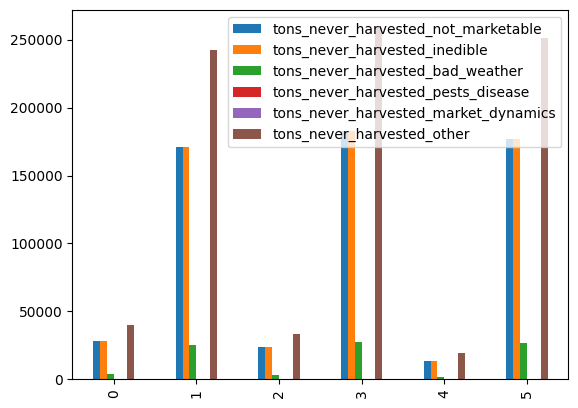

In [263]:
final[['tons_never_harvested_not_marketable',
 'tons_never_harvested_inedible',
 'tons_never_harvested_bad_weather',
 'tons_never_harvested_pests_disease',
 'tons_never_harvested_market_dynamics',
 'tons_never_harvested_other']].plot(kind="bar")

# ax = final.plot(x="refed_food_department", y=['tons_never_harvested_not_marketable',
#  'tons_never_harvested_inedible',
#  'tons_never_harvested_bad_weather',
#  'tons_never_harvested_pests_disease',
#  'tons_never_harvested_market_dynamics',
#  'tons_never_harvested_other'], kind="bar", rot=0, stacked=True)


In [267]:

for i in ['tons_never_harvested_not_marketable',
 'tons_never_harvested_inedible',
 'tons_never_harvested_bad_weather',
 'tons_never_harvested_pests_disease',
 'tons_never_harvested_market_dynamics',
 'tons_never_harvested_other']:
    fig = px.histogram(final, x="year", y=i,
                 color='refed_food_department', barmode='group',
                 histfunc='sum',
                 height=400, text_auto='.2s',
                title=i)
    fig.show()

# Part 3: Analysis

See script at: https://github.com/margieh/reFed_working/blob/main/src/pipeline.py